# 3 TESTING NOTEBOOK - TEST 2

In [1]:
# INSTALL SCIKERAS PACKAGES
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# IMPORT TENSORFLOW/KERAS
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions

from keras.layers.core import Flatten
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# SCIKIT-LEARN/SCIKERAS
from sklearn import preprocessing
import sklearn.metrics as metrics
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report

# IMPORT OTHER MODULES
import os
import sys
import glob
import datetime
from pathlib import Path

import fnmatch # to count number of image per folder easily
import random # to select random images from a folder
import numpy as np
import pandas as pd
from os import mkdir
import seaborn as sns
from pathlib import Path
from shutil import copyfile # to import "copyfile"
from numpy.random import seed
import matplotlib.image as img_mat
import plotly.figure_factory as ff # for printing the heatmap
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython.display import Javascript

# CV2
import cv2
from google.colab.patches import cv2_imshow 

In [3]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# CONSTANT
SEED_VALUE = 42
num_classes = 9 # number of output classes
batch_size = 16
SIZE = 224  #Resize images --> https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network#:~:text=So%20the%20rule%20of%20thumb,for%20something%20smaller%20and%20easier.

# PATH TO THE DATA
ORIGINAL_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset"
base_path_test = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/'
DIR_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/*' # path contenente i sottoinsiemi di train, test

In [5]:
# # # Capture training data and labels into respective lists
# # train_images = []
# # train_labels = [] 

# # # GET THE LABELS
# # for directory_path in glob.glob(DIR_TRAIN_DATA):
# #     tr_label = directory_path.split("/")[-1]
# #     print(tr_label)
# #     # GET THE IMAGES
# #     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
# #         # print(img_path)
# #         img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
# #         img = cv2.resize(img, (SIZE, SIZE))
# #         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# #         train_images.append(img)
# #         train_labels.append(tr_label)

# # # CONVERT LISTS TO ARRAYS
# # train_images = np.array(train_images)
# # train_labels = np.array(train_labels)

# ################################################################
# # CAPTURE TEST/VALIDATION DATA AND LABELS INTO RESPECTIVE LISTS

# test_images = []
# test_labels = [] 
# for directory_path in glob.glob(DIR_TEST_DATA):
#     tt_label = directory_path.split("/")[-1]
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         img = cv2.resize(img, (SIZE, SIZE))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#         test_images.append(img)
#         test_labels.append(tt_label)

# #Convert lists to arrays                
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)

In [6]:
# def prep_fn(img):
#     img = img.astype(np.float32) / 255.0
#     img = (img - 0.5) * 2
#     return img

In [7]:
preprocess_input_mobilenetV2 = tf.keras.applications.mobilenet_v2.preprocess_input

In [8]:
# test_datagen_mnetv2 = ImageDataGenerator() # rescale=1./255
test_datagen_mnetv2 = ImageDataGenerator(preprocessing_function = preprocess_input_mobilenetV2) 

# TOGLIERE: USARE SOLO NEL NOTEBOOK DI TEST!
test_generator = test_datagen_mnetv2.flow_from_directory(
    base_path_test,
    target_size=(SIZE, SIZE), # target_size=(224,224),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

Found 155 images belonging to 9 classes.


In [9]:
ground_truth_dict = test_generator.class_indices
ground_truth_dict

{'caesar_salad': 0,
 'caprese_salad': 1,
 'french_fries': 2,
 'greek_salad': 3,
 'hamburger': 4,
 'hot_dog': 5,
 'pizza': 6,
 'sashimi': 7,
 'sushi': 8}

In [10]:
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from keras.applications.mobilenet_v2 import preprocess_input
# from keras.applications.vgg16 import preprocess_input

def prepare_image(file_input, show=True):
    img = image.load_img(file_input, target_size=(SIZE, SIZE))
    img_array = image.img_to_array(img)
    # img_array_expanded_dims = preprocess_input(img_array)
    # img_array= (img_array/255.0)
    img_array = img_array.astype(np.float32) / 255.0
    img_array = (img_array - 0.5) * 2
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    # img_array_expanded_dims = preprocess_input(img_array_expanded_dims)

    if show:
      plt.imshow(img_array_expanded_dims[0])                           
      plt.axis('off')
      plt.show()

    return img_array_expanded_dims

    # return img_array_expanded_dims

In [11]:
# CREATE A LIST TO STORE THE PATH OF EACH RANDOM IMAGE
inference_data = list()

# current_directory = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset")
# current_directory = Path('/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/')
current_directory = Path(base_path_test)
# current_directory = Path('/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed')

for folder in current_directory.iterdir():
  split_str = str(folder).split("/")[-1] # get the folder name
  print(split_str)
  file_path_type = [f"{current_directory}/{split_str}/*.jpg"]  
  # print(file_path_type)
  images = glob.glob(random.choice(file_path_type))
  # print(images)

  for i in range(1):
    # if len(inference_data) > 1:
    #   break
    random_image = random.choice(images)
    # print(random_image)
    inference_data.append(random_image)
    # img_raw = cv2.imread(random_image)
    print(inference_data)
    print("------------")

french_fries
['/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/french_fries/french_fries_71.jpg_RESIZED.jpg']
------------
caprese_salad
['/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/french_fries/french_fries_71.jpg_RESIZED.jpg', '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/caprese_salad/crop_caesar7.jpg_RESIZED.jpg']
------------
pizza
['/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/french_fries/french_fries_71.jpg_RESIZED.jpg', '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/caprese_salad/crop_caesar7.jpg_RESIZED.jpg', '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Second

In [12]:
# LOAD SAVED MODEL AND GET PATH FOR AN IMAGE
best_model = tf.keras.models.load_model("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/model_mobilenetV2.h5") 

In [13]:
# im_test = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/hot_dog/20160711_1214411.jpg_RESIZED.jpg'

In [14]:
# img = image.load_img(im_test, target_size=(224,224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# print(full_model.predict(x))
# plt.imshow(img)

french_fries


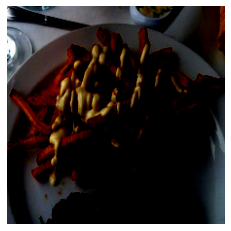

1/1 [==============================] - 1s 1s/step
Output index is: [3]

The food predicted is: greek_salad.
------------------------ NEXT IMAGE ----------------------------

caprese_salad


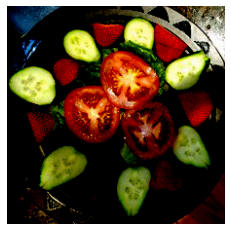

1/1 [==============================] - 0s 75ms/step
Output index is: [6]

The food predicted is: pizza.
------------------------ NEXT IMAGE ----------------------------

pizza


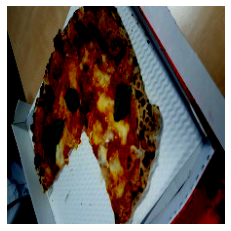

1/1 [==============================] - 0s 60ms/step


Output index is: [8]

The food predicted is: sushi.
------------------------ NEXT IMAGE ----------------------------

greek_salad


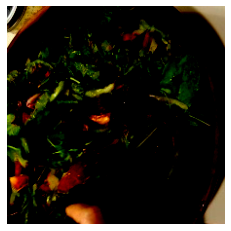

1/1 [==============================] - 0s 63ms/step
Output index is: [2]

The food predicted is: french_fries.
------------------------ NEXT IMAGE ----------------------------

sashimi


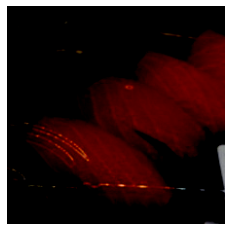

1/1 [==============================] - 0s 64ms/step
Output index is: [8]

The food predicted is: sushi.
------------------------ NEXT IMAGE ----------------------------

hot_dog


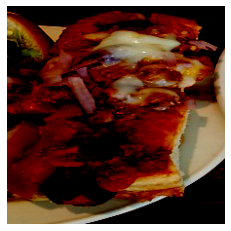

1/1 [==============================] - 0s 61ms/step


Output index is: [7]

The food predicted is: sashimi.
------------------------ NEXT IMAGE ----------------------------

caesar_salad


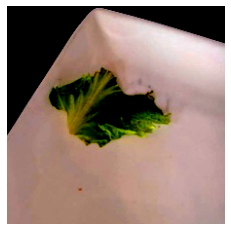

1/1 [==============================] - 0s 60ms/step
Output index is: [2]

The food predicted is: french_fries.
------------------------ NEXT IMAGE ----------------------------

hamburger


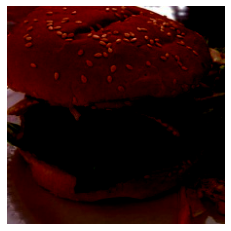

1/1 [==============================] - 0s 60ms/step


Output index is: [3]

The food predicted is: greek_salad.
------------------------ NEXT IMAGE ----------------------------

sushi


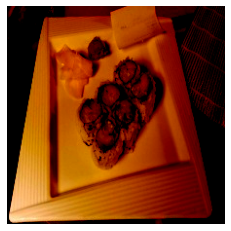

1/1 [==============================] - 0s 60ms/step
Output index is: [0]

The food predicted is: caesar_salad.
------------------------ NEXT IMAGE ----------------------------

Predicted: [3, 6, 8, 2, 8, 7, 2, 3, 0]
Ground Truth [2, 1, 6, 3, 7, 5, 0, 4, 8]


In [15]:
pred_output_list = list()
ground_truth_list = list()
ground_truth_dict = test_generator.class_indices

for image_path in inference_data:
  split_str = str(image_path).split("/")[-2] # get the folder name
  print(split_str)
  new_image = prepare_image(image_path)
  # print(new_image.shape)
  pred = best_model.predict(new_image)

  # Generate arg maxes for predictions
  # output_index = np.argmax(pred[[0]], axis = 1)
  output_index = np.argmax(pred, axis = 1)
  print("Output index is:", output_index)

  pred_output_list.append(output_index[0])
  ground_truth_list.append(ground_truth_dict[f'{split_str}'])

  # if max(pred[0]) < 0.50:
  #   print("I'm sorry, I cannot recognise any type of food here! Try again!")
  #   print("The groud truth is", split_str)
  # else:
  #   value = [i for i in test_generator.class_indices if test_generator.class_indices[i]==np.argmax(pred, axis = 1)]
  #   print(f"The food in this image should be: {value[0]}.")
  #   print("The groud truth is", split_str, ".")
  
  print("")
  value = [i for i in test_generator.class_indices if test_generator.class_indices[i] == output_index]
  print(f"The food predicted is: {value[0]}.")
  print("------------------------ NEXT IMAGE ----------------------------")
  print("")

print("Predicted:", pred_output_list)
print("Ground Truth", ground_truth_list)

In [16]:
# CREATE A DATAFRAME TO COMPARE THE RESULTS
df_comparison = pd.DataFrame({"predicted": pred_output_list, "ground truth": ground_truth_list})

df_comparison['comparison'] = np.where(df_comparison['predicted'] == df_comparison['ground truth'], 1, 
                                      np.where(df_comparison['predicted'] !=  df_comparison['ground truth'], 0, -1))

df_comparison

,predicted,ground truth,comparison
0,3,2,0
1,6,1,0
2,8,6,0
3,2,3,0
4,8,7,0
5,7,5,0
6,2,0,0
7,3,4,0
8,0,8,0


**MIGLIOR RISULTATO FINORA. POTREBBE ESSERE UN PROBLEMA DI INDICI???**

In [17]:
# COMPUTE ACCURACY OVER THE TEN ELEMENTS
accuracy_over_test = (np.sum(df_comparison['comparison'])/len(df_comparison))*100
print(f"Accuracy over {len(df_comparison)} images is:", accuracy_over_test, "%")

Accuracy over 9 images is: 0.0 %


**SPECIFICARE CHE I BAD RESULTS SONO DATI DA SUSHI E SASHIMI**

QUELLO CHE POTRESTI FARE E' PROVARE CON UN ALTRO DATASET FOOD E RIFARE LA STESSA COSA CON UN DATASET DIVERSO E MAGARE USARNE UN ALTRO ANCHE!